In [57]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [58]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [4]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


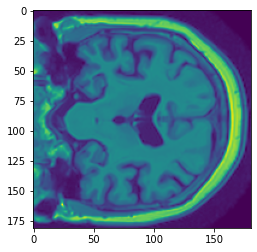

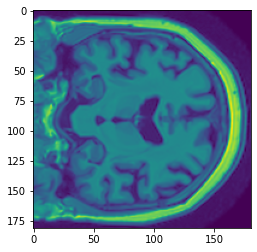

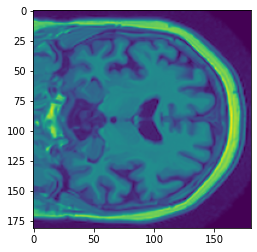

In [67]:
def sagital_adjacent_slices(img_n_mmni, m, epsilon, y_tuple, z_tuple):
    crop_img = img_n_mmni.slicer[m-epsilon:m+epsilon+1:epsilon, y_tuple[0]:y_tuple[1], z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (1, 2, 0))
    return crop_img

def coronal_adjacent_slices(img_n_mmni, x_tuple, m, epsilon, z_tuple):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], m-epsilon:m+epsilon+1:epsilon, z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (0, 2, 1))
    return crop_img

def axial_adjacent_slices(img_n_mmni, x_tuple, y_tuple, m, epsilon):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], y_tuple[0]:y_tuple[1], m-epsilon:m+epsilon+1:epsilon]
    return crop_img.get_fdata()

img_data = sagital_adjacent_slices(img_n_mmni, 10, 5, (0,217),(0,181))

#img_data = np.transpose(img_data, (1, 2, 0))

#181,217,181
img_data = coronal_adjacent_slices(img_n_mmni, (0,181), 110, 5,(0,181))

for i in range(3):
    plt.imshow(img_data[:, :, i])
    plt.show()

In [70]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head(7)


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [73]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            
            for i in range(-4,4):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (40+i,80+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (40+i,80+i))
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
            
            
            for i in range(-4,4):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (40+i,80+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (40+i,80+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)
                
                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
                    
            """if Y['Group'][index] == 'AD':
                Y_data.append(1)
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)
                Y_data.append(0)
            """
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [74]:
X_data, Y_data = Data_preparation(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(6704, 3, 40, 40, 3)
6704


In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=49) 

print("Data splited, length of training data is: ", len(X_train))
print("Data splited, length of test data is: ", len(X_test))

Data splited, length of training data is:  5363
Data splited, length of test data is:  1341


In [76]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def intermediate_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32

    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    
    num_filters *= 2
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(intermediate_network(inputs=inputs, i=i, padding='same'))

    x = Concatenate(name = "Concat1")(out_list)
    x = Flatten(name = "Flatten1")(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)
    
    return Model(inputs, outputs)

    
model_2 = create_model_2D_epsilon(X_train[0].shape)
model_2.summary()
model_2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
     

    

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_48 (S  (None, 40, 40, 3)   0           ['input_17[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_49 (S  (None, 40, 40, 3)   0           ['input_17[0][0]']               
 licingOpLambda)                                                                           

In [77]:
history = model_2.fit(X_train, Y_train, epochs=70, validation_data=(X_test, Y_test))

Epoch 1/70
168/168 [==============================] - 45s 197ms/step - loss: 0.6558 - accuracy: 0.6849 - val_loss: 0.5729 - val_accuracy: 0.7845
Epoch 2/70
168/168 [==============================] - 32s 192ms/step - loss: 0.5247 - accuracy: 0.7630 - val_loss: 0.4685 - val_accuracy: 0.8069
Epoch 3/70
168/168 [==============================] - 31s 186ms/step - loss: 0.4714 - accuracy: 0.7871 - val_loss: 0.3992 - val_accuracy: 0.8262
Epoch 4/70
168/168 [==============================] - 32s 188ms/step - loss: 0.4252 - accuracy: 0.8107 - val_loss: 0.4409 - val_accuracy: 0.8084
Epoch 5/70
168/168 [==============================] - 31s 185ms/step - loss: 0.4065 - accuracy: 0.8173 - val_loss: 0.3600 - val_accuracy: 0.8523
Epoch 6/70
168/168 [==============================] - 31s 187ms/step - loss: 0.3896 - accuracy: 0.8236 - val_loss: 0.3611 - val_accuracy: 0.8412
Epoch 7/70
168/168 [==============================] - 31s 187ms/step - loss: 0.3790 - accuracy: 0.8363 - val_loss: 0.3570 - val_ac

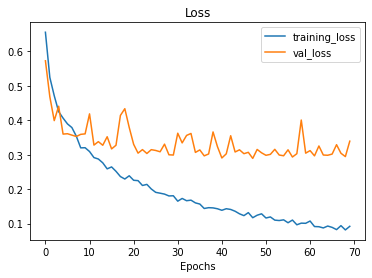

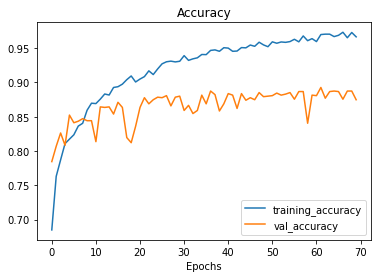

In [78]:
def plot_loss_curves(history):
      
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      # Plot loss
      plt.plot(epochs, loss, label='training_loss')
      plt.plot(epochs, val_loss, label='val_loss')
      plt.title('Loss')
      plt.xlabel('Epochs')
      plt.legend()

      # Plot accuracy
      plt.figure()
      plt.plot(epochs, accuracy, label='training_accuracy')
      plt.plot(epochs, val_accuracy, label='val_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()

plot_loss_curves(history)